# Simulate dropout smearing

Try to simulate a complex function f: R->R. Let a model train on it. Then shift the function up and use dropout. How good will it adapt? Will there be smearing?

Import libraries

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from torch.nn.functional import relu
from torch import nn
import torch
from torch.utils.data import DataLoader,TensorDataset

# Define helper functions

In [2]:
def plot_loss_hist(train_loss_hist, eval_loss_hist):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_hist, label='Training Loss', color='blue')
    plt.plot(eval_loss_hist, label='Validation Loss', color='orange')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

In [3]:
def plot_functions(x,layer,n_func=None,):
    if n_func is None:
        n_func = layer.bias.size(0)

    weights = layer.weight.detach().numpy()
    bias = layer.bias.detach().numpy()
    y_acc = torch.zeros_like(torch.from_numpy(x))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Functions')
    

    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Accumulated functions')
    

    for i in range(n_func):
        f = lambda x: relu(torch.from_numpy(weights[i,] * x + bias[i]))
        y = f(x)
        ax1.plot(x,y, label=f'func_{i}')

        y_acc += y
        ax2.plot(x,y_acc, label=f'acc_func_{i}')
    
    ax1.legend()
    ax1.grid(True)
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    # Show the combined figure
    plt.show()

In [4]:
from statistics import mean
def create_dataloaders(x, y, batch_size=16, train_frac=0.6, plot_data=False):
    train_mask = np.zeros([x.shape[0]],dtype=bool)
    train_mask[:int(train_frac*x.shape[0])] = 1
    np.random.shuffle(train_mask)
    test_mask = ~train_mask

    if plot_data:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

        # Plot the first line plot on the first subplot
        ax1.plot(x[train_mask], y[train_mask], label='train', color='blue')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Training data')
        ax1.legend()
        ax1.axvline(min(x[train_mask]), 0.1, 0.9, color='k', linestyle='--')
        ax1.text(min(x[train_mask]), mean(y[train_mask]), f'x_min = {min(x[train_mask])}', ha='center', va='center',rotation='vertical', bbox={'facecolor':'white', 'pad':5})

        ax1.axvline(max(x[train_mask]), 0.1, 0.9, color='k', linestyle='--')
        ax1.text(max(x[train_mask]), mean(y[train_mask]), f'x_max = {max(x[train_mask])}', ha='center', va='center',rotation='vertical', bbox={'facecolor':'white', 'pad':5})


        # Plot the second line plot on the second subplot
        ax2.plot(x[test_mask], y[test_mask], label='test', color='green')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Test data')
        ax2.legend()
        ax2.axvline(min(x[test_mask]), 0.1, 0.9, color='k', linestyle='--')
        ax2.text(min(x[test_mask]), mean(y[test_mask]), f'x_min = {min(x[test_mask])}', ha='center', va='center',rotation='vertical', bbox={'facecolor':'white', 'pad':5})
        ax2.axvline(max(x[test_mask]), 0.1, 0.9, color='k', linestyle='--')
        ax2.text(max(x[test_mask]), mean(y[test_mask]), f'x_max = {max(x[test_mask])}', ha='center', va='center',rotation='vertical', bbox={'facecolor':'white', 'pad':5})

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show the combined figure
        plt.show()

    train_set = TensorDataset(torch.from_numpy(x[train_mask]), torch.from_numpy(y[train_mask]))
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

    test_set = TensorDataset(torch.from_numpy(x[test_mask]), torch.from_numpy(y[test_mask]))
    test_dataloader= DataLoader(test_set, batch_size=batch_size, shuffle=False)

    dataloaders = {'train':train_loader,
                'eval':test_dataloader}
    return dataloaders


In [5]:
import time
class early_stopping_callback:
  def __init__(self,min_delta=0,patience=1):
    self.min_delta=min_delta
    self.patience=patience
    self.counter=0
    self.lowest_loss=np.inf
  def check_early_stopping(self,eval_loss):
    delta =  self.lowest_loss - eval_loss
    if delta >= self.min_delta:
      self.lowest_loss = eval_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False
  
    
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5, verbose = 0,plot_intermediate=False):
    since = time.time()
    if verbose > 0:
      modulo_coeff = 10
    else:
      modulo_coeff = 100

    patience = 10
    es_callback = early_stopping_callback(min_delta=0,patience=patience)

    train_loss_hist = []
    eval_loss_hist = []

    for epoch in range(num_epochs):
        if epoch % modulo_coeff == 0:
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        ############ train phase ############
        phase = 'train'
        model.train()

        running_loss = 0.0

        for batch_number, (inputs, labels) in enumerate(dataloaders[phase]):
          if use_modded:
            # #++++++++ catch gradient ++++++++#
            # disable gradient insertion for catch run
            hooks_dict['insert_hook'].disable_insertion()

            # set the dropout to the desired value during the catch run
            for module, p in zip(dropout_modules,catch_dropouts):
                module.p = p
            
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1))
            loss = loss_fn(outputs, labels.unsqueeze(1).float())
            loss.backward()          

            # update gradient to be inserted
            hooks_dict['insert_hook'].update_grad(hooks_dict['catch_hook'].caught_grad)

            # set the dropout to the desired value during the insertion run
            for module, p in zip(dropout_modules,insert_dropouts):
                module.p = p
            
            
            # re-enable gradient insertion for insertion run
            hooks_dict['insert_hook'].enable_insertion()
            # #++++++++ \catch gradient ++++++++#


          # Unregularized run
          optimizer.zero_grad()
          outputs = model(inputs.unsqueeze(1))
          loss = loss_fn(outputs, labels.unsqueeze(1).float())
          loss.backward()          
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)

        train_epoch_loss = running_loss / len(dataloaders[phase].dataset)
        train_loss_hist.append(train_epoch_loss)

        if verbose > 0:
           print('{} Loss: {:.4f}'.format(phase, train_epoch_loss))

        ############ eval phase ############
        phase = 'eval'
        model.eval()

        running_loss = 0.0

        for batch_number, (inputs, labels) in enumerate(dataloaders[phase]):
          # disable gradient tracking for speedup
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs.unsqueeze(1))
            loss = loss_fn(outputs, labels.unsqueeze(1).float())

          running_loss += loss.item() * inputs.size(0)

        eval_epoch_loss = running_loss / len(dataloaders[phase].dataset)
        eval_loss_hist.append(eval_epoch_loss)
        
        if es_callback.check_early_stopping(eval_epoch_loss):
          print(f"Stopping early after epoch {epoch}")
          break

        if verbose > 0:
           print('{} Loss: {:.4f}'.format(phase, eval_epoch_loss))  


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return {"train" : train_loss_hist, "eval" : eval_loss_hist}

In [6]:
def plot_model_mapping(model, x, y_true=None,seed=None):
    
    predictions = model(torch.from_numpy(x).unsqueeze(-1))
    plt.plot(x,predictions.detach().numpy(), label='model prediction')
    if y_true is not None:
        plt.plot(x,y_true, label='ground truth')
    plt.xlabel("x")
    plt.ylabel('y')
    plt.legend()

In [7]:
def attach_hooks_to_layer(layer, original_gradient_fraction=0):
    class Catch_Hook():
        def __init__(self, module):
            self.hook = module.register_full_backward_hook(self.hook_fn)

        def hook_fn(self, module, grad_input, grad_output):
            self.caught_grad = grad_output
            # print('caught a gradient:')
            # print(self.caught_grad)

        def close(self):
            self.hook.remove()


    class Insert_Hook():
        def __init__(self, module, insertion_enabled = False, new_grad_output=None, original_gradient_fraction=0):
            self.new_grad_output = new_grad_output
            # use prepend=True so that this is definitely the first hook being applied
            self.hook = module.register_full_backward_pre_hook(self.hook_fn,prepend=True)
            self.insertion_enabled = insertion_enabled
            assert (0 <= original_gradient_fraction <= 1), "Gradient fraction should be between 0 and 1"
            self.original_gradient_fraction = original_gradient_fraction

        def hook_fn(self, module, grad_output):
            if self.insertion_enabled:
            # simply return the previously caught grad_output
            # this will replace the current grad_output (if prehook is used)
            # if non-pre hook is used, grad_input will be replaced (not desire in our case)
                if self.original_gradient_fraction > 0:
                    ogf = self.original_gradient_fraction
                    return ogf * grad_output + (1-ogf) * self.new_grad_output
                else:
                    return self.new_grad_output

        def update_grad(self, new_grad_output):
            self.new_grad_output = new_grad_output

        def close(self):
            self.hook.remove()

        def enable_insertion(self):
            self.insertion_enabled = True

        def disable_insertion(self):
            self.insertion_enabled = False

    #++++++++++++++++++ attach hooks to the specified layer ++++++++++++++++++++++++#
    hooks = {}
    hooks['catch_hook'] = Catch_Hook(layer)
    hooks['insert_hook'] = Insert_Hook(layer)
    #++++++++++++++++++ \attach hooks to the specified layer ++++++++++++++++++++++++#

    return hooks

# Create dataset

Create artifical input data

In [8]:
n_samples = 100
x_min = 0
x_max = 4
x = np.linspace(x_min,x_max,n_samples, dtype=np.float32)
y_min = 0
y_max = 4


array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.5050505 ,  0.6060606 ,  0.7070707 ,  0.8080808 ,  0.90909094,
        1.010101  ,  1.1111112 ,  1.2121212 ,  1.3131313 ,  1.4141414 ,
        1.5151515 ,  1.6161616 ,  1.7171717 ,  1.8181819 ,  1.919192  ,
        2.020202  ,  2.121212  ,  2.2222223 ,  2.3232324 ,  2.4242425 ,
        2.5252526 ,  2.6262627 ,  2.7272727 ,  2.8282828 ,  2.929293  ,
        3.030303  ,  3.131313  ,  3.2323232 ,  3.3333333 ,  3.4343433 ,
        3.5353534 ,  3.6363637 ,  3.7373738 ,  3.838384  ,  3.939394  ,
        4.040404  ,  4.141414  ,  4.242424  ,  4.3434343 ,  4.4444447 ,
        4.5454545 ,  4.646465  ,  4.7474747 ,  4.848485  ,  4.949495  ,
        5.050505  ,  5.151515  ,  5.2525253 ,  5.353535  ,  5.4545455 ,
        5.5555553 ,  5.6565657 ,  5.757576  ,  5.858586  ,  5.959596  ,
        6.060606  ,  6.1616163 ,  6.262626  ,  6.3636365 ,  6.4646463 ,
        6.5656567 ,  6.6666665 ,  6.767677  ,  6.8686867 ,  6.96

Create and plot ground truth data

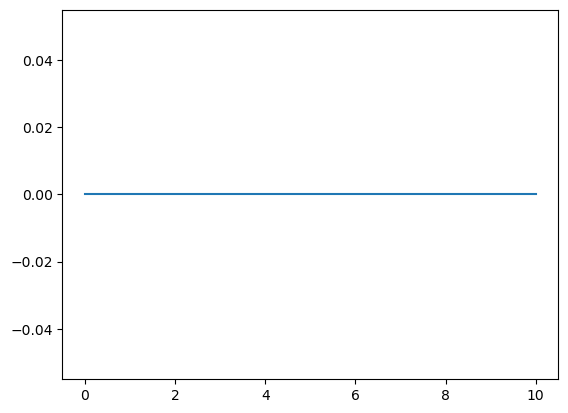

In [9]:
f = lambda x: np.sin(x) + np.sin(x/7) + np.sin(x/5) - np.sin(x/3) + np.sin(9*x) * np.exp(-x ** 2) + 1.5 + np.random.normal(0,2e-2,x.shape)
f = lambda x: 0*np.ones_like(x)
y = f(x)
plt.plot(x,y)

Create train and evaluation split. Also create dataloaders.

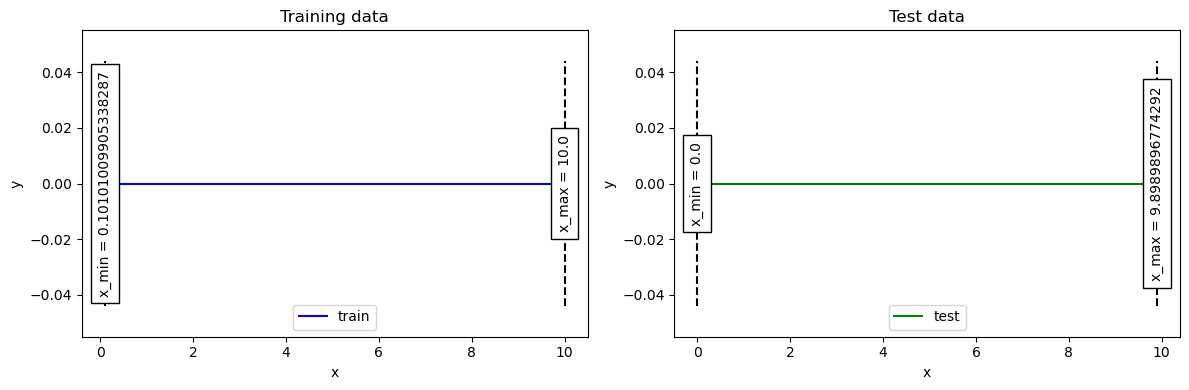

In [10]:
dataloaders = create_dataloaders(x,y,plot_data=True)

# Define model architecture

Create model architecture function.

In [20]:
class LinearNet(nn.Module):
    def __init__(self, hidden_size=2, dropout_p=0):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.relu = nn.ReLU()
        self.do = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.do(x)
        x = self.fc2(x)
        return x

Model with dropout

In [21]:
sgd_parameters = {
    'lr':1e-5,        # undefined
    'momentum':0,   # 0
    'dampening':0,    # 0
    'weight_decay':0  # 0
}
loss_fn = nn.MSELoss()
model = LinearNet(dropout_p=0.5, hidden_size=512)
optimizer = torch.optim.SGD(model.parameters(), **sgd_parameters)
use_modded = False

hist = train_model(
    model,
    dataloaders,
    loss_fn,
    optimizer,
    num_epochs=3000,
    plot_intermediate=False
    )

Epoch 0/2999
Stopping early after epoch 15
Training complete in 0m 0s


In [14]:
for p in model.named_parameters():
    print(p)

('fc1.weight', Parameter containing:
tensor([[-0.1135],
        [ 0.7258]], requires_grad=True))
('fc1.bias', Parameter containing:
tensor([1.1351, 0.5139], requires_grad=True))
('fc2.weight', Parameter containing:
tensor([[0.9852, 0.1541]], requires_grad=True))
('fc2.bias', Parameter containing:
tensor([0.8026], requires_grad=True))


plot train and eval loss

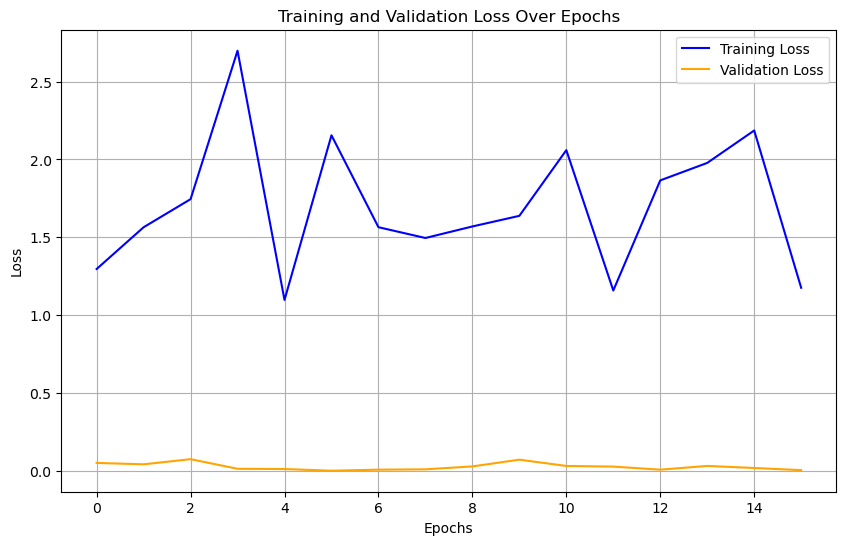

In [22]:
plot_loss_hist(hist["train"],hist["eval"])

Plot model function

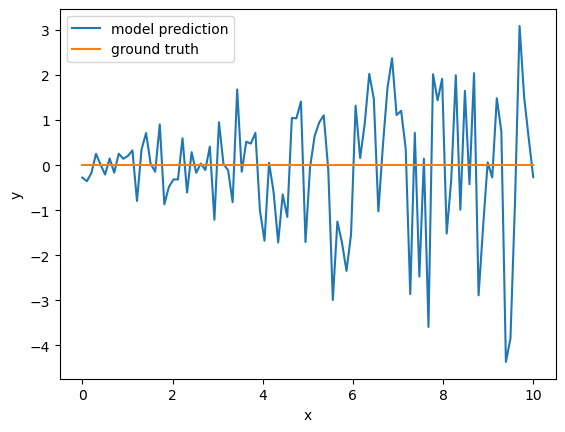

In [23]:
model.train()
plot_model_mapping(model, x, y)

print parameter weights

In [20]:
for p in model.named_parameters():
    # print(p)
    variance = np.var(p[1].detach().numpy())
    print(f'Variance in {p[0]} {variance}')

Variance in fc1.weight 0.10890351235866547
Variance in fc1.bias 0.00881489459425211
Variance in fc2.weight 0.009423347190022469
Variance in fc2.bias 0.0


show piecewise functions

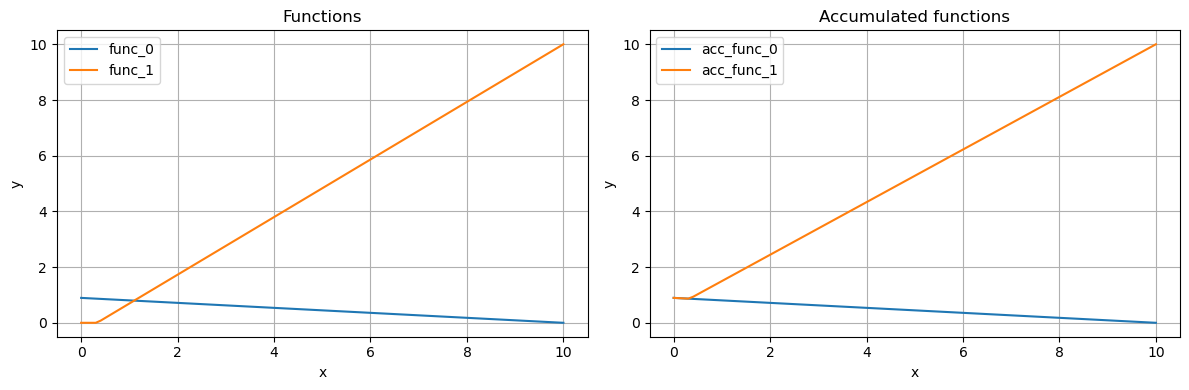

In [120]:
plot_functions(x,model.fc1)

## Finetuning

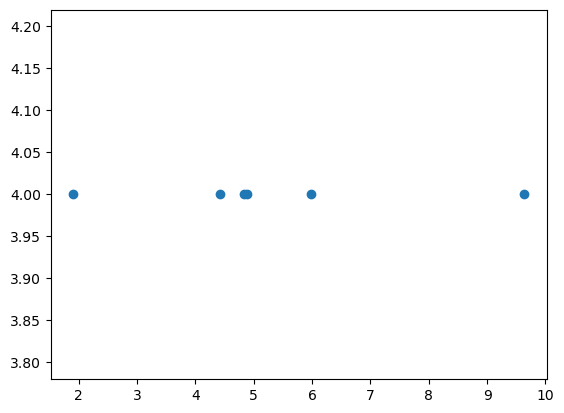

In [95]:
x_finetune = (np.random.random(6)*10).astype(np.float32)
f_finetune = lambda x: 4*np.ones_like(x)
y_finetune = f_finetune(x_finetune)
plt.scatter(x_finetune,y_finetune)

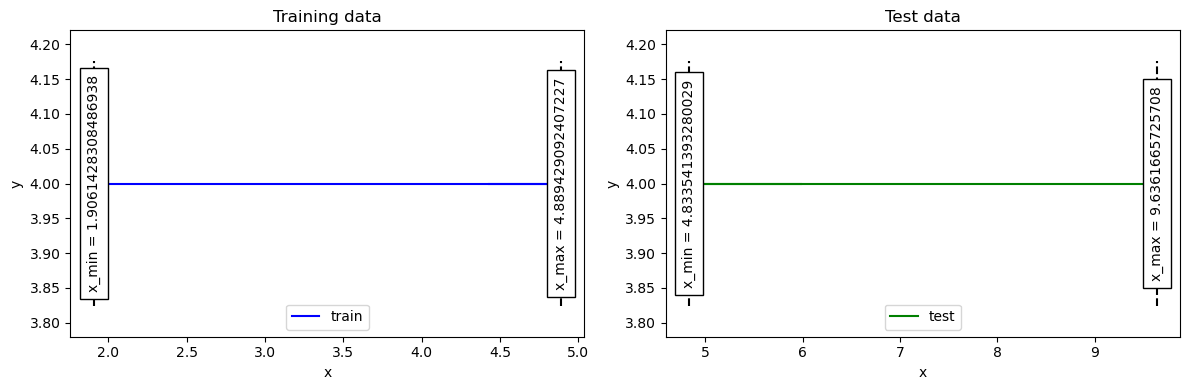

In [96]:
dataloaders_finetune = create_dataloaders(x_finetune,y_finetune, plot_data=True)

In [97]:
use_modded = False

# Modded preparation
hooks_dict = attach_hooks_to_layer(model.fc2)#, args.original_gradient_fraction)
dropout_modules = [module for module in model.modules() if isinstance(module,torch.nn.Dropout)]
catch_dropout = 0
catch_dropouts = [catch_dropout for _ in dropout_modules]
insert_dropout = 0
insert_dropouts = [insert_dropout for _ in dropout_modules]
for module, p in zip(dropout_modules,insert_dropouts):
        module.p = p
        
hist_finetune = train_model(
    model,
    dataloaders_finetune,
    loss_fn,
    optimizer,
    num_epochs=3000
    )

Epoch 0/2999
Stopping early after epoch 13
Training complete in 0m 0s


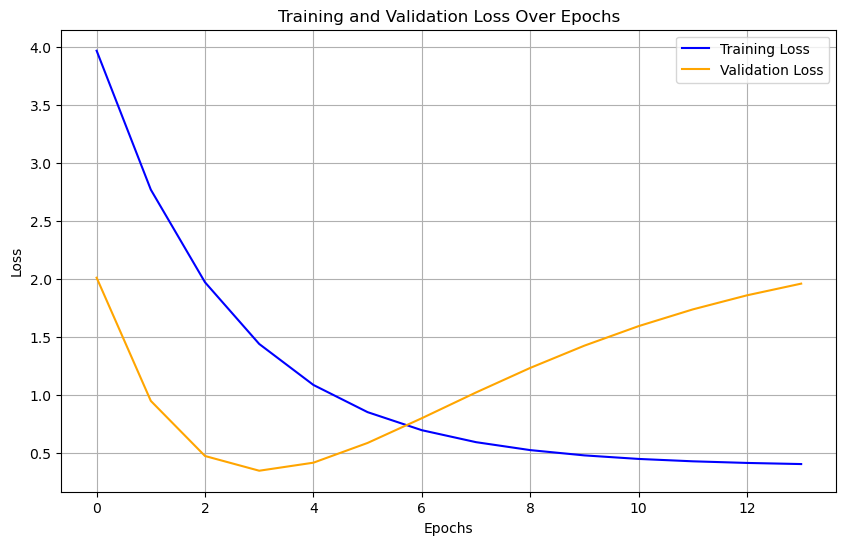

In [98]:
plot_loss_hist(hist_finetune["train"],hist_finetune["eval"])

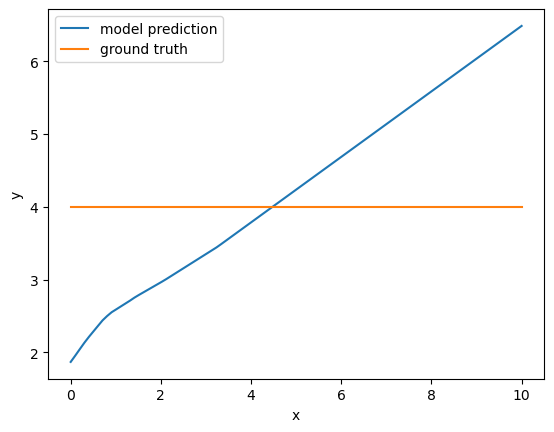

In [99]:
plot_model_mapping(model, x, f_finetune(x))

# Old

In [31]:
model.fc1.weight = torch.nn.Parameter(torch.tensor([[-1.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]]))
print(model.fc1.weight)
model.fc1.bias = torch.nn.Parameter(torch.tensor([0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0]))
print(model.fc1.bias)
model.fc2.weight = torch.nn.Parameter(torch.tensor([[0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]))
print(model.fc2.weight)
model.fc1.bias = torch.nn.Parameter(torch.tensor([0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0]))
print(model.fc1.bias)

Parameter containing:
tensor([[-1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], requires_grad=True)
Parameter containing:
tensor([0.9000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       requires_grad=True)
Parameter containing:
tensor([[0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       requires_grad=True)
Parameter containing:
tensor([0.9900, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       requires_grad=True)


In [32]:
for param in model.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[-1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.]], requires_grad=True))
('fc1.bias', Parameter containing:
tensor([0.9900, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       requires_grad=True))
('fc2.weight', Parameter containing:
tensor([[0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       requires_grad=True))
('fc2.bias', Parameter containing:
tensor([0.9883], requires_grad=True))


In [20]:
for param in model.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[-0.8865],
        [ 0.4241],
        [ 0.1196],
        [ 0.8044],
        [ 0.5714],
        [-0.4208],
        [-0.6756],
        [ 0.4726]], requires_grad=True))
('fc1.bias', Parameter containing:
tensor([ 0.9042,  0.8536, -0.3502, -0.4362, -0.6332, -0.8554, -0.3618,  0.6926],
       requires_grad=True))
('fc2.weight', Parameter containing:
tensor([[ 0.3123,  0.3939,  0.0489, -0.2489, -0.3659, -0.1358,  0.2268,  0.5013]],
       requires_grad=True))
('fc2.bias', Parameter containing:
tensor([0.9883], requires_grad=True))


Epoch 0/2999
Epoch 100/2999
Epoch 200/2999
Epoch 300/2999
Epoch 400/2999
Epoch 500/2999
Epoch 600/2999
Epoch 700/2999
Epoch 800/2999
Epoch 900/2999
Epoch 1000/2999
Epoch 1100/2999
Epoch 1200/2999
Epoch 1300/2999
Epoch 1400/2999
Epoch 1500/2999
Epoch 1600/2999
Epoch 1700/2999
Epoch 1800/2999
Epoch 1900/2999
Epoch 2000/2999
Epoch 2100/2999
Epoch 2200/2999
Epoch 2300/2999
Epoch 2400/2999
Epoch 2500/2999
Epoch 2600/2999
Epoch 2700/2999
Epoch 2800/2999
Epoch 2900/2999
Training complete in 0m 19s
Epoch 0/2999
Epoch 100/2999
Epoch 200/2999
Epoch 300/2999
Epoch 400/2999
Epoch 500/2999
Epoch 600/2999
Epoch 700/2999
Epoch 800/2999
Epoch 900/2999
Epoch 1000/2999
Epoch 1100/2999
Epoch 1200/2999
Epoch 1300/2999
Epoch 1400/2999
Epoch 1500/2999
Epoch 1600/2999
Epoch 1700/2999
Epoch 1800/2999
Epoch 1900/2999
Epoch 2000/2999
Epoch 2100/2999
Epoch 2200/2999
Epoch 2300/2999
Epoch 2400/2999
Epoch 2500/2999
Epoch 2600/2999
Epoch 2700/2999
Epoch 2800/2999
Epoch 2900/2999
Training complete in 0m 21s
Epoch 0/

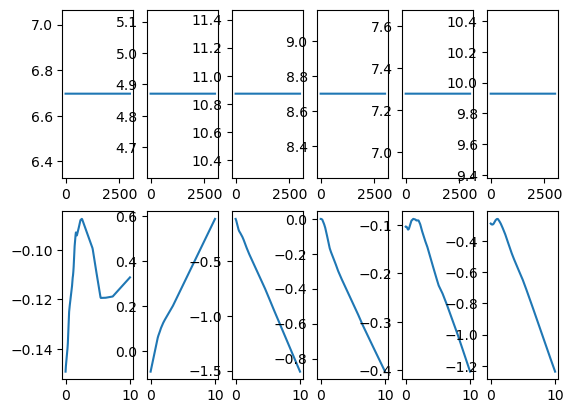

In [35]:
sgd_parameters = {
    'lr':1e-3,        # undefined
    'momentum':0,   # 0
    'dampening':0,    # 0
    'weight_decay':0  # 0
}
loss_fn = nn.MSELoss()
dropout_list = [0, 0.2, 0.4, 0.6, 0.8, 0.9]

fig, axs = plt.subplots(2, len(dropout_list))

for idx, dropout_prob in enumerate(dropout_list):
    optimizer = torch.optim.SGD(model.parameters(), **sgd_parameters)
    model = LinearNet(dropout_prob)
    hist = train_model(model,
                    dataloaders,
                    loss_fn,
                    optimizer,
                    num_epochs=3000
                    )

    axs[0,idx].plot(hist)
    axs[1,idx].plot(x,model(torch.from_numpy(x).unsqueeze(1)).detach().numpy())

# Fixfreezeing dropout layers

In [27]:
# from torch import nn
# torch.manual_seed(0)
# dropout = nn.Dropout(p=0.5)
# x = torch.tensor([1.0,2.0])
# dropout(x)

tensor([2., 0.])